In [ ]:
# Import necessary libraries for sentiment analysis
# Data manipulation and analysis
import json
import os
import logging

from datetime import datetime
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd

# Text processing and regex
import re
import unicodedata

# Machine learning and model evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import FeatureUnion

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import numpy as np

# Environment variables
from dotenv import load_dotenv
import os

# Set random seed for reproducibility
np.random.seed(1)
logging.basicConfig(level=logging.INFO)

In [ ]:
# Load the training and test datasets
# Data is tab-separated (TSV format)
TRAIN_PATH = "train.tsv"
TEST_PATH  = "test.tsv"

train_df = pd.read_csv(TRAIN_PATH, sep="\t")
test_df  = pd.read_csv(TEST_PATH,  sep="\t")

# Display the shape of datasets and preview training data
print(train_df.shape, test_df.shape)
train_df.head()

(156060, 4) (66292, 3)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
# Count the total number of unique PhraseId entries and unique SentenceId entries
# This helps understand the data structure - one sentence can have multiple phrases
print("unique PhraseId count:", train_df['PhraseId'].nunique())
print("unique SentenceId count:", train_df['SentenceId'].nunique())

unique PhraseId count: 156060
unique SentenceId count: 8529


<Axes: xlabel='Sentiment'>

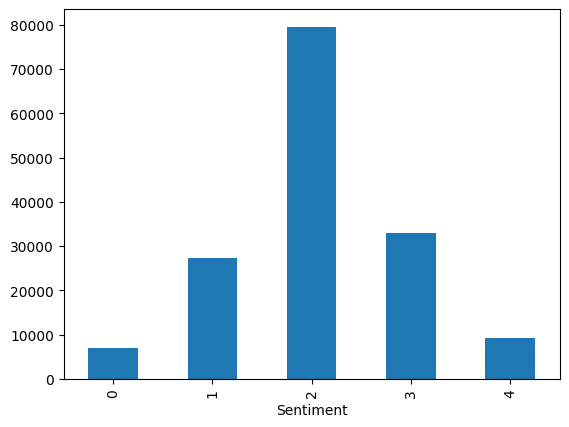

In [ ]:
# Visualize the distribution of sentiment classes
# 0: Very Negative, 1: Negative, 2: Neutral, 3: Positive, 4: Very Positive
train_df['Sentiment'].value_counts().sort_index().plot(kind='bar')

In [ ]:
# Feature engineering: Calculate the number of words in each phrase

train_df["n_words"] = train_df["Phrase"].astype(str).str.split().apply(len)
train_df["n_words"].describe()

count    156060.000000
mean          7.203364
std           7.024604
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max          52.000000
Name: n_words, dtype: float64

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Boxplot of Number of Words by Sentiment')

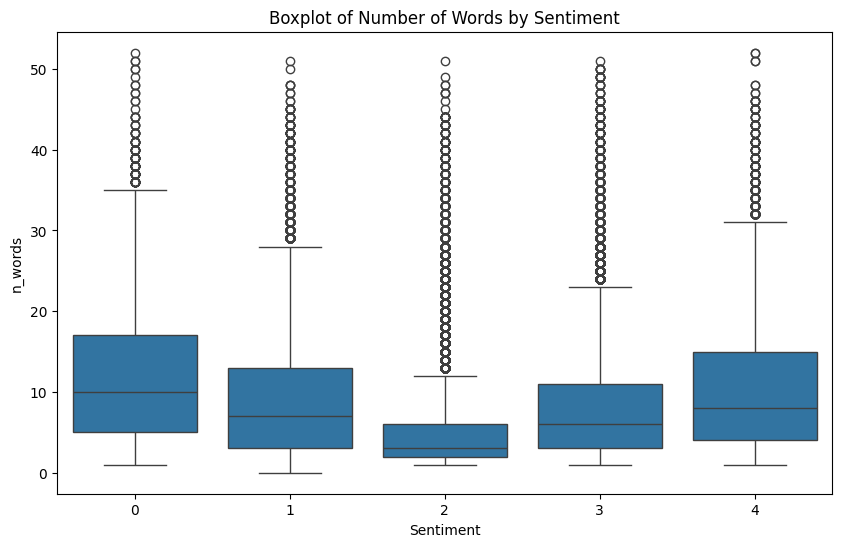

In [ ]:
# Create a boxplot to explore the relationship between phrase length and sentiment
# This helps identify if sentiment categories have different phrase length patterns
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment', y='n_words', data=train_df)
plt.title('Boxplot of Number of Words by Sentiment')

In [ ]:
# Function to generate word clouds for each sentiment category
# This helps visualize the most common words associated with each sentiment
def plot_wordcloud_for_sentiment(df, sentiment_label, title, text_col="Phrase"):
    # Extract all phrases for the given sentiment
    s = df.loc[df["Sentiment"] == sentiment_label, text_col].astype(str)
    text = " ".join(s.values)

    # Check if there's any text to process
    if not text.strip():
        print(f"No text found for sentiment={sentiment_label}")
        return
    
    # Define domain-specific stopwords to filter out common movie review terms
    # These words don't provide useful information about sentiment
    domain_stopwords = {
    "movie", "movies", "film", "films",
    "story", "stories",
    "character", "characters",
    "director", "directors",
    "plot", "plots",
    "scene", "scenes",
    "screenplay", "script",
    "performance", "performances",
    "cast", "acting", "actor", "actors",
    "cinema", "theater", "theatre"
}
    
    # Combine default stopwords with domain-specific ones
    custom_stopwords = STOPWORDS.union(domain_stopwords)
    
    # Generate word cloud
    wc = WordCloud(
        width=900,
        height=450,
        background_color="white",
        stopwords=custom_stopwords,
        max_words=200,
        collocations=False  # Avoid treating bigrams as single words
    ).generate(text)

    # Convert to image array for plotting
    img = wc.to_image()      # PIL image, avoids __array__ conversion issues
    arr = np.array(img)      # Convert to numpy array

    # Display the word cloud
    plt.figure(figsize=(14, 6))
    plt.imshow(arr, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

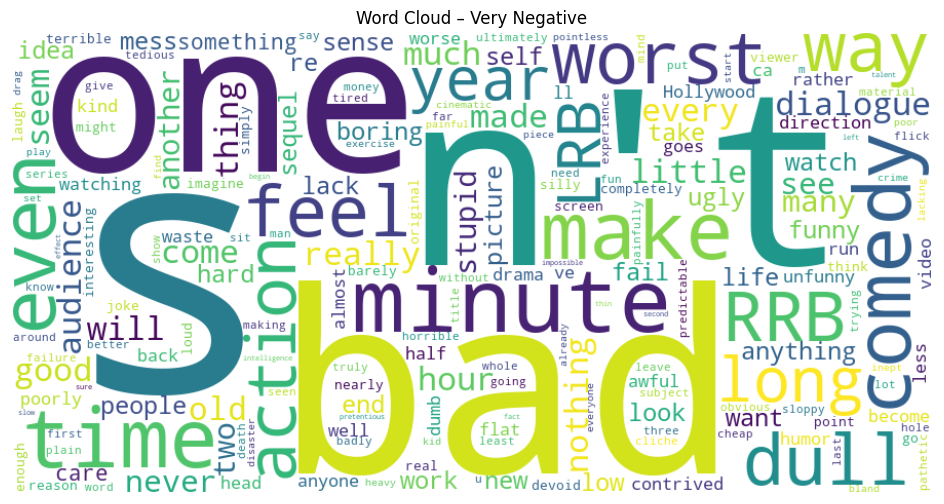

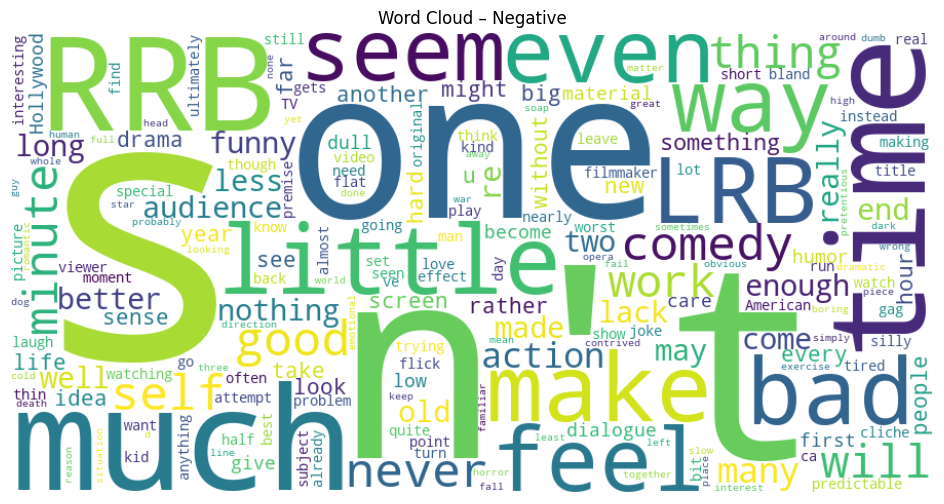

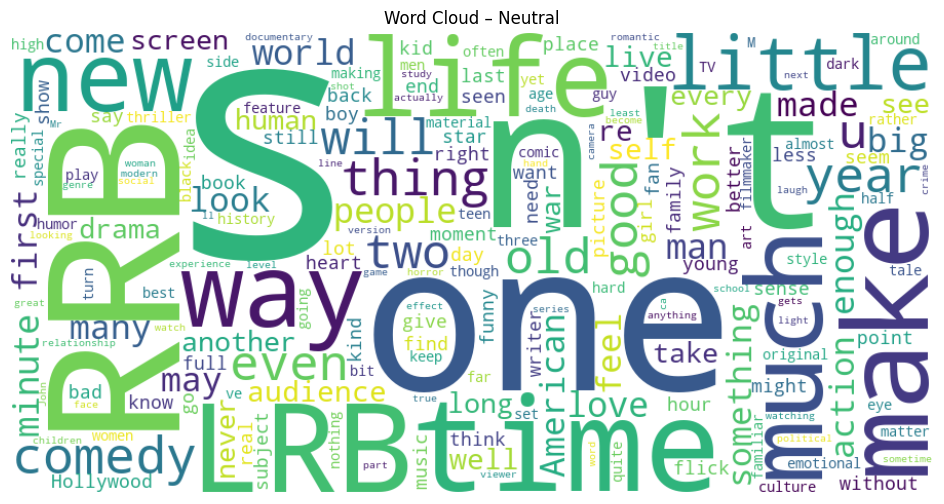

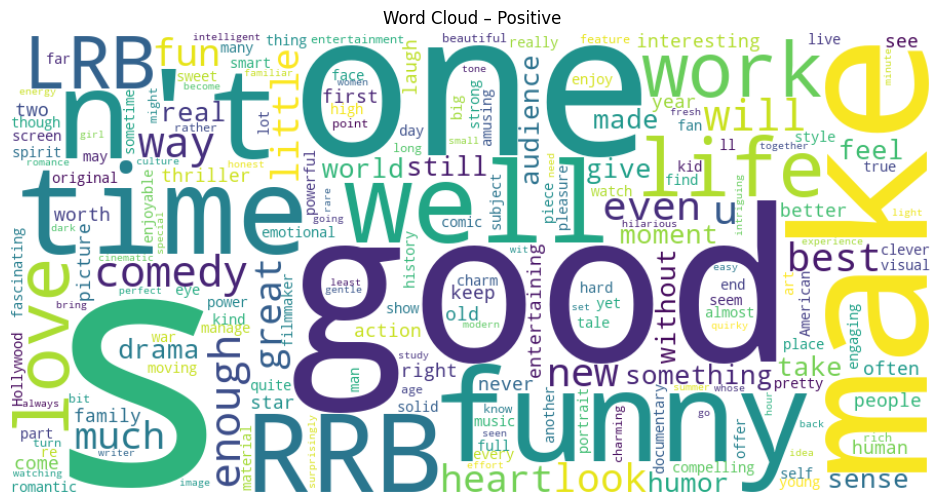

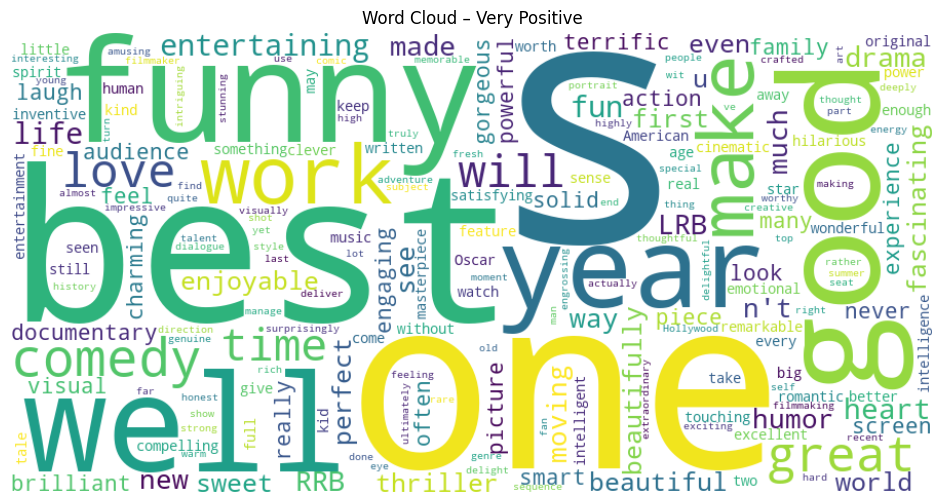

In [ ]:
# Define sentiment labels for better readability
sentiment_map = {
    0: "Very Negative",
    1: "Negative",
    2: "Neutral",
    3: "Positive",
    4: "Very Positive"
}

# Generate a word cloud for each sentiment category
for s, name in sentiment_map.items():
    plot_wordcloud_for_sentiment(train_df, s, f"Word Cloud – {name}")

In [ ]:
# Prepare features (X) and target (y) for modeling
X = train_df["Phrase"].astype(str)
y = train_df["Sentiment"].astype(int)

# Split data into training and validation sets
# stratify=y ensures the sentiment distribution is preserved in both sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,      # 20% for validation
    random_state=42,    # For reproducibility
    stratify=y          # Maintain sentiment distribution
)

print(X_train.shape, X_val.shape)

(124848,) (31212,)


In [ ]:
# Create a basic pipeline with TF-IDF vectorization and Logistic Regression
model = Pipeline([
    # TF-IDF: Convert text to numerical features based on term frequency-inverse document frequency
    ("tfidf", TfidfVectorizer(
        lowercase=True,              # Convert all text to lowercase
        ngram_range=(1, 2),          # Use unigrams and bigrams
        min_df=2,                    # Ignore terms that appear in fewer than 2 documents
        max_df=0.95,                 # Ignore terms that appear in more than 95% of documents
        strip_accents="unicode"      # Remove accents from characters
    )),
    # Logistic Regression classifier for multi-class sentiment classification
    ("clf", LogisticRegression(
        max_iter=2000,               # Maximum iterations for convergence
        n_jobs=-1                    # Use all available CPU cores
    ))
])

model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                                 strip_accents='unicode')),
                ('clf', LogisticRegression(max_iter=2000, n_jobs=-1))])

In [ ]:
# Train the baseline model on the training data
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                                 strip_accents='unicode')),
                ('clf', LogisticRegression(max_iter=2000, n_jobs=-1))])

In [ ]:
# Evaluate the baseline model on the validation set
val_pred = model.predict(X_val)

# Calculate and display accuracy
acc = accuracy_score(y_val, val_pred)
print("Validation accuracy:", acc)

# Show detailed classification metrics for each sentiment class
print("\nClassification report:")
print(classification_report(y_val, val_pred, digits=4))

# Display confusion matrix to see where the model makes mistakes
print("\nConfusion matrix:")
print(confusion_matrix(y_val, val_pred))

Validation accuracy: 0.6492695117262591

Classification report:
              precision    recall  f1-score   support

           0     0.6108    0.2086    0.3110      1414
           1     0.5683    0.4055    0.4733      5455
           2     0.6795    0.8815    0.7674     15917
           3     0.5949    0.4890    0.5368      6585
           4     0.6542    0.2754    0.3876      1841

    accuracy                         0.6493     31212
   macro avg     0.6215    0.4520    0.4952     31212
weighted avg     0.6376    0.6493    0.6243     31212


Confusion matrix:
[[  295   697   391    28     3]
 [  157  2212  2961   120     5]
 [   29   875 14031   954    28]
 [    2    97  3034  3220   232]
 [    0    11   232  1091   507]]


In [ ]:
# Text preprocessing function to clean and normalize text
def clean_text_basic(text: str) -> str:
    if text is None:
        return ""
    # Ensure string type
    text = str(text)

    # Normalize unicode characters to their standard forms
    # e.g., "ﬁ" → "fi", "½" → "1/2"
    text = unicodedata.normalize("NFKC", text)

    # Remove control characters (rare, but can appear)
    # e.g., null bytes, tabs, newlines, etc.
    text = re.sub(r"[\x00-\x1f\x7f-\x9f]", " ", text)

    # Collapse multiple whitespace characters into a single space
    # Also trim leading and trailing whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [ ]:
# Create an enhanced model with both word-level and character-level features

# Word-level TF-IDF: Captures word patterns and semantic meaning
word_tfidf = TfidfVectorizer(
    preprocessor=clean_text_basic,   # Apply text cleaning
    lowercase=True,
    ngram_range=(1, 2),              # Unigrams and bigrams
    min_df=2,
    max_df=0.95,
    strip_accents="unicode"
)

# Character-level TF-IDF: Captures spelling patterns, handles typos and informal text
char_tfidf = TfidfVectorizer(
    preprocessor=clean_text_basic,
    lowercase=True,
    analyzer="char",                 # Use character n-grams instead of words
    ngram_range=(3, 5),              # Character n-grams from 3 to 5 characters
    min_df=2
)

# Combine both feature extractors into a single feature union
# This allows the model to learn from both word and character patterns
features = FeatureUnion([
    ("word", word_tfidf),
    ("char", char_tfidf)
])

# Create the enhanced pipeline
model_plus = Pipeline([
    ("features", features),           # Combined word and character features
    ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
])

In [ ]:
# Perform 5-fold stratified cross-validation to get a more robust estimate of model performance
# Stratified ensures each fold has the same sentiment distribution as the full dataset

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(
    model_plus,
    X_train,
    y_train,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1                        # Use all CPU cores for parallel processing
)

# Display cross-validation results
print("CV accuracy scores:", np.round(cv_scores, 4))
print("CV mean accuracy:", cv_scores.mean())
print("CV std:", cv_scores.std())

CV accuracy scores: [0.663  0.6574 0.6631 0.6629 0.6615]
CV mean accuracy: 0.6615885014197742
CV std: 0.002166244434899845


In [ ]:
# Train the enhanced model on the full training set
model_plus.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('word',
                                                 TfidfVectorizer(max_df=0.95,
                                                                 min_df=2,
                                                                 ngram_range=(1,
                                                                              2),
                                                                 preprocessor=<function clean_text_basic at 0x15ffec220>,
                                                                 strip_accents='unicode')),
                                                ('char',
                                                 TfidfVectorizer(analyzer='char',
                                                                 min_df=2,
                                                                 ngram_range=(3,
                                                                              5),
                                                                 preprocessor=<function clean_text_basic at 0x15ffec220>))])),
                ('clf', LogisticRegression(max_iter=2000, n_jobs=-1))])

In [ ]:
# Evaluate the enhanced model on the validation set
val_pred = model_plus.predict(X_val)

# Calculate and display accuracy
acc = accuracy_score(y_val, val_pred)
print("Validation accuracy:", acc)

# Show detailed metrics for each sentiment class
print("\nClassification report:")
print(classification_report(y_val, val_pred, digits=4))

# Display confusion matrix to analyze prediction errors
print("\nConfusion matrix:")
print(confusion_matrix(y_val, val_pred))

Validation accuracy: 0.671921056004101

Classification report:
              precision    recall  f1-score   support

           0     0.5707    0.2970    0.3907      1414
           1     0.5727    0.4889    0.5275      5455
           2     0.7224    0.8573    0.7841     15917
           3     0.6094    0.5437    0.5746      6585
           4     0.6250    0.3585    0.4556      1841

    accuracy                         0.6719     31212
   macro avg     0.6200    0.5091    0.5465     31212
weighted avg     0.6598    0.6719    0.6579     31212


Confusion matrix:
[[  420   752   219    21     2]
 [  267  2667  2371   144     6]
 [   46  1104 13645  1089    33]
 [    3   119  2528  3580   355]
 [    0    15   125  1041   660]]


In [ ]:
# Analyze misclassified examples to understand model errors
# This helps identify patterns in mistakes and potential improvements
val_results = pd.DataFrame({
    "phrase": X_val.values,
    "y_true": y_val.values,
    "y_pred": val_pred
})

# Filter to show only incorrect predictions
mistakes = val_results[val_results["y_true"] != val_results["y_pred"]]
mistakes.head(20)

,phrase,y_true,y_pred
0,"passionate , if somewhat flawed ,",2,3
8,reflect,3,2
9,darned assured,3,2
11,it is also a work of deft and subtle poetry,2,3
16,above its oh-so-Hollywood rejiggering and its ...,4,3
19,bound to show up at theatres for it,3,2
21,is why I have given it a one-star rating,0,1
25,add up to more than body count,1,2
27,is so often less than the sum of its parts in ...,0,2
29,making it par for the course for Disney sequels,1,2


In [ ]:
# Final training: Retrain the model on the entire training dataset
# This uses all available training data to maximize model performance for predictions
model_plus.fit(X, y)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('word',
                                                 TfidfVectorizer(max_df=0.95,
                                                                 min_df=2,
                                                                 ngram_range=(1,
                                                                              2),
                                                                 preprocessor=<function clean_text_basic at 0x15ffec220>,
                                                                 strip_accents='unicode')),
                                                ('char',
                                                 TfidfVectorizer(analyzer='char',
                                                                 min_df=2,
                                                                 ngram_range=(3,
                                                                              5),
                                                                 preprocessor=<function clean_text_basic at 0x15ffec220>))])),
                ('clf', LogisticRegression(max_iter=2000, n_jobs=-1))])

In [ ]:
# Generate predictions for the test set and create submission file
submission_pred = model_plus.predict(test_df["Phrase"].astype(str))

# Create submission DataFrame in the required format
submission_df = pd.DataFrame({
    "PhraseId": test_df["PhraseId"],
    "Sentiment": submission_pred
})

# Save predictions to CSV file for Kaggle submission
submission_df.to_csv("submission.csv", index=False)